In [49]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

In [5]:
path = kagglehub.dataset_download("tunguz/internet-firewall-data-set")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\khand\.cache\kagglehub\datasets\tunguz\internet-firewall-data-set\versions\1


In [14]:
df = pd.read_csv(path + "\\log2.csv")
print("Dataset loaded successfully.")

Dataset loaded successfully.


In [15]:
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [28]:
df.shape

(65532, 12)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


In [17]:
df.describe()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,65532.000000,65532.000000,65532.000000,65532.000000,6.553200e+04,6.553200e+04,6.553200e+04,6.553200e+04,65532.000000,65532.000000,65532.000000
mean,49391.969343,10577.385812,19282.972761,2671.049930,9.712395e+04,2.238580e+04,7.473815e+04,1.028660e+02,65.833577,41.399530,61.466505
std,15255.712537,18466.027039,21970.689669,9739.162278,5.618439e+06,3.828139e+06,2.463208e+06,5.133002e+03,302.461762,3218.871288,2223.332271
min,0.000000,0.000000,0.000000,0.000000,6.000000e+01,6.000000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
25%,49183.000000,80.000000,0.000000,0.000000,6.600000e+01,6.600000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
50%,53776.500000,445.000000,8820.500000,53.000000,1.680000e+02,9.000000e+01,7.900000e+01,2.000000e+00,15.000000,1.000000,1.000000
75%,58638.000000,15000.000000,38366.250000,443.000000,7.522500e+02,2.100000e+02,4.490000e+02,6.000000e+00,30.000000,3.000000,2.000000
max,65534.000000,65535.000000,65535.000000,65535.000000,1.269359e+09,9.484772e+08,3.208818e+08,1.036116e+06,10824.000000,747520.000000,327208.000000


In [19]:
df.isnull().sum()

Source Port             0
Destination Port        0
NAT Source Port         0
NAT Destination Port    0
Action                  0
Bytes                   0
Bytes Sent              0
Bytes Received          0
Packets                 0
Elapsed Time (sec)      0
pkts_sent               0
pkts_received           0
dtype: int64

In [24]:
def identify_column_types(df, numerical_threshold=10, object_is_categorical_default=True):
    numerical_cols = []
    categorical_cols = []

    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            if df[col].nunique() < numerical_threshold:
                categorical_cols.append(col)
            else:
                numerical_cols.append(col)
        elif pd.api.types.is_object_dtype(df[col]) or pd.api.types.is_string_dtype(df[col]):
            if object_is_categorical_default:
                categorical_cols.append(col)
        else:
            if df[col].nunique() < numerical_threshold * 2:
                categorical_cols.append(col)

    print(f"\nIdentified Numerical Columns: {numerical_cols}")
    print(f"Identified Categorical Columns: {categorical_cols}")
    return numerical_cols, categorical_cols

numerical_cols, categorical_cols = identify_column_types(df)


Identified Numerical Columns: ['Source Port', 'Destination Port', 'NAT Source Port', 'NAT Destination Port', 'Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received']
Identified Categorical Columns: ['Action']



Value Counts for 'Action':
Action
allow         37640
deny          14987
drop          12851
reset-both       54
Name: count, dtype: int64


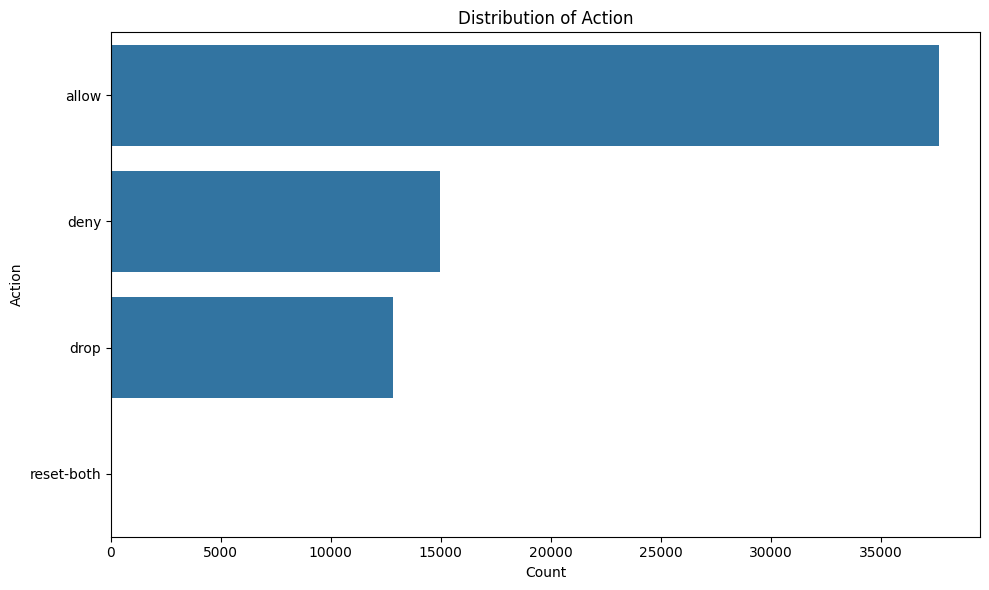

In [35]:
def analyze_categorical_features(df, categorical_cols):
    for col in categorical_cols:
        if col not in df.columns:
            print(f"Warning: Categorical column '{col}' not found in DataFrame. Skipping.")
            continue

        print(f"\nValue Counts for '{col}':")
        print(df[col].value_counts())

        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, y=col, order=df[col].value_counts().index)
        plt.title(f'Distribution of {col}')
        plt.xlabel('Count')
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()
        
analyze_categorical_features(df, categorical_cols)


Descriptive Statistics for 'Source Port':
count    65532.000000
mean     49391.969343
std      15255.712537
min          0.000000
25%      49183.000000
50%      53776.500000
75%      58638.000000
max      65534.000000
Name: Source Port, dtype: float64


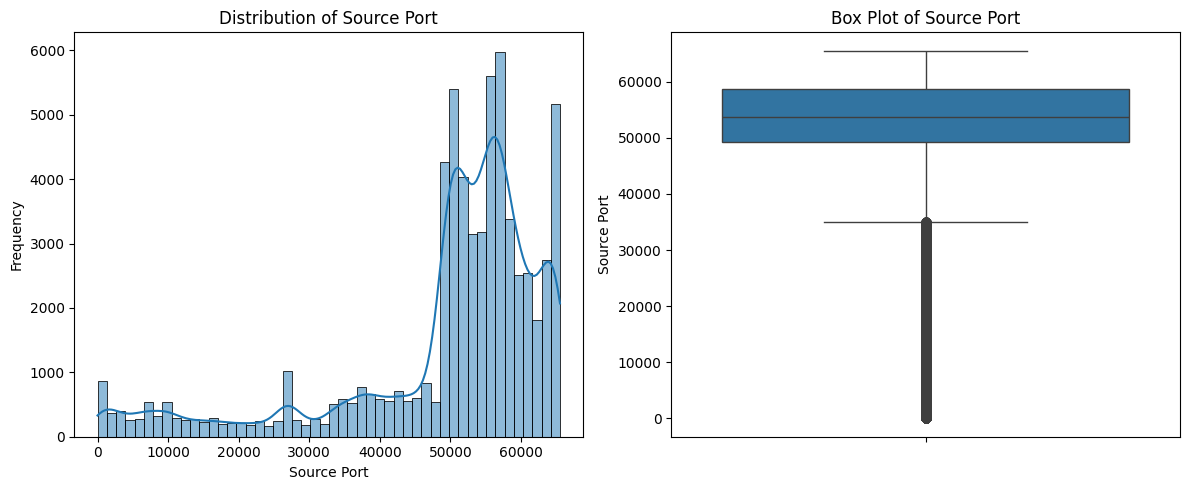

-------------------------------------------------------------

Descriptive Statistics for 'Destination Port':
count    65532.000000
mean     10577.385812
std      18466.027039
min          0.000000
25%         80.000000
50%        445.000000
75%      15000.000000
max      65535.000000
Name: Destination Port, dtype: float64


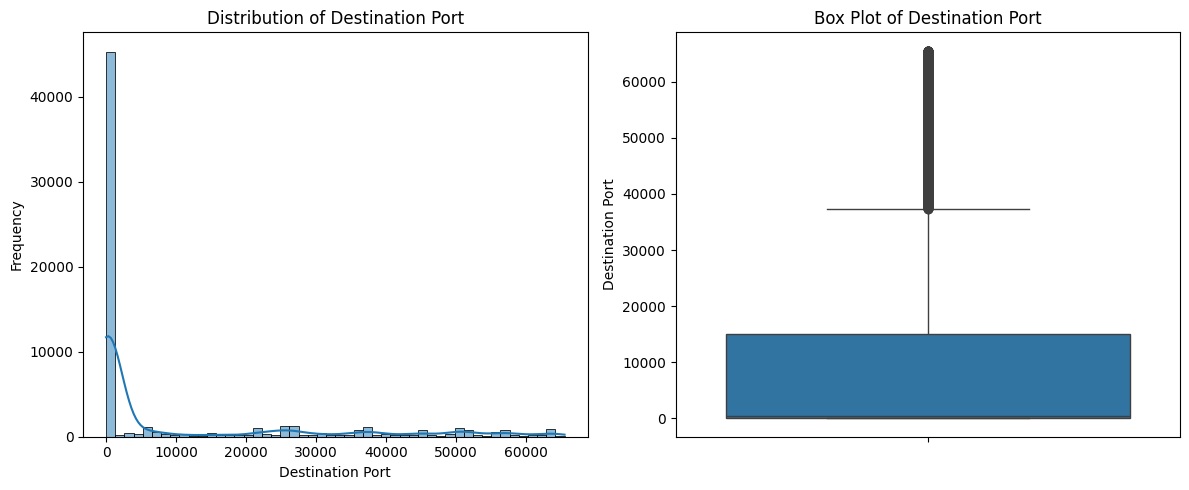

-------------------------------------------------------------

Descriptive Statistics for 'NAT Source Port':
count    65532.000000
mean     19282.972761
std      21970.689669
min          0.000000
25%          0.000000
50%       8820.500000
75%      38366.250000
max      65535.000000
Name: NAT Source Port, dtype: float64


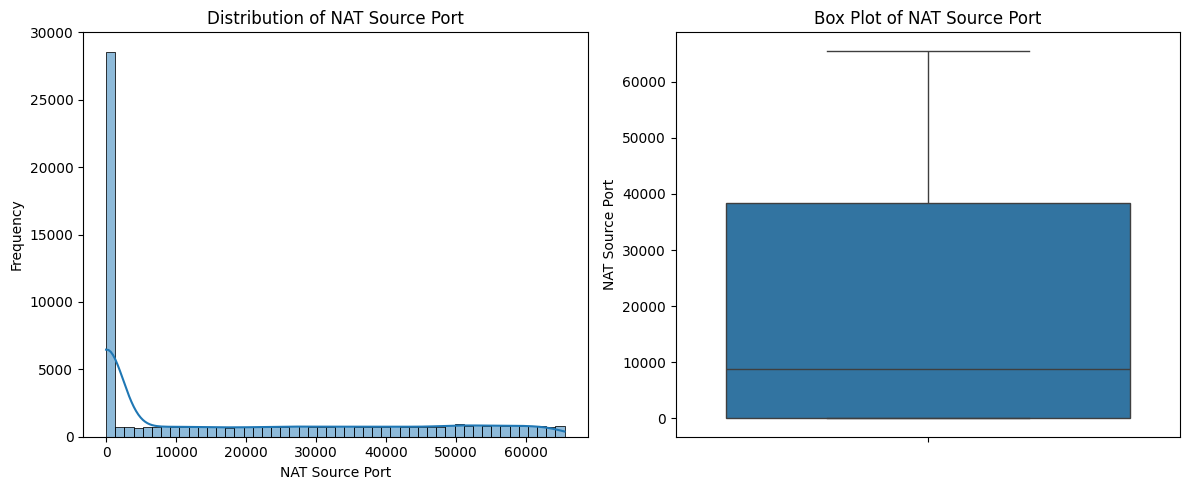

-------------------------------------------------------------

Descriptive Statistics for 'NAT Destination Port':
count    65532.000000
mean      2671.049930
std       9739.162278
min          0.000000
25%          0.000000
50%         53.000000
75%        443.000000
max      65535.000000
Name: NAT Destination Port, dtype: float64


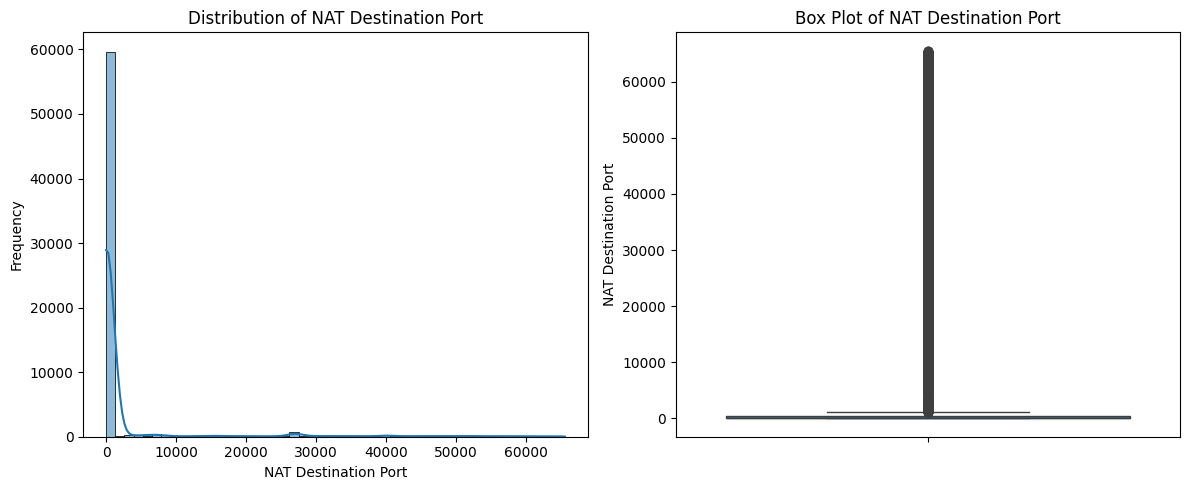

-------------------------------------------------------------

Descriptive Statistics for 'Bytes':
count    6.553200e+04
mean     9.712395e+04
std      5.618439e+06
min      6.000000e+01
25%      6.600000e+01
50%      1.680000e+02
75%      7.522500e+02
max      1.269359e+09
Name: Bytes, dtype: float64


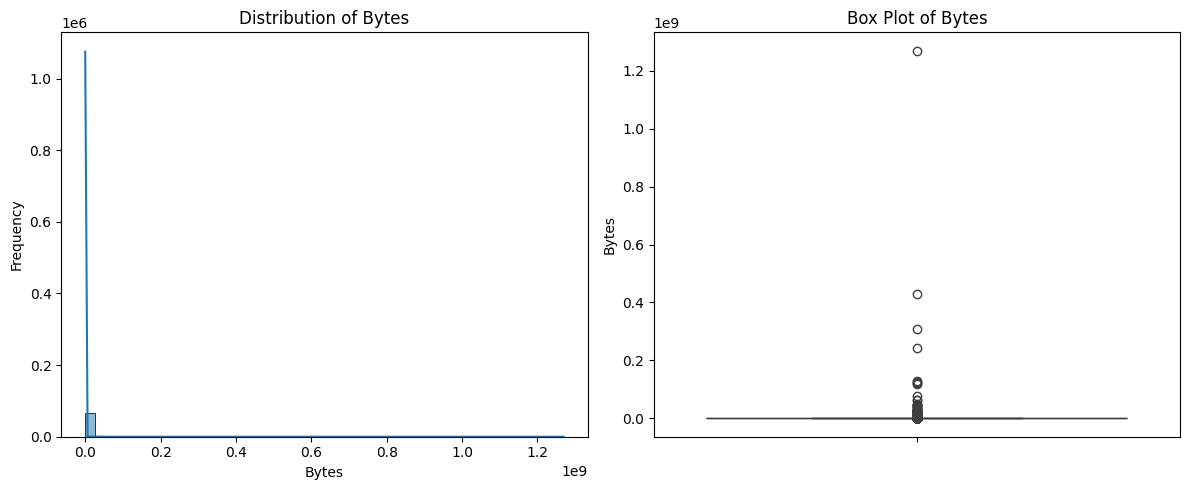

-------------------------------------------------------------

Descriptive Statistics for 'Bytes Sent':
count    6.553200e+04
mean     2.238580e+04
std      3.828139e+06
min      6.000000e+01
25%      6.600000e+01
50%      9.000000e+01
75%      2.100000e+02
max      9.484772e+08
Name: Bytes Sent, dtype: float64


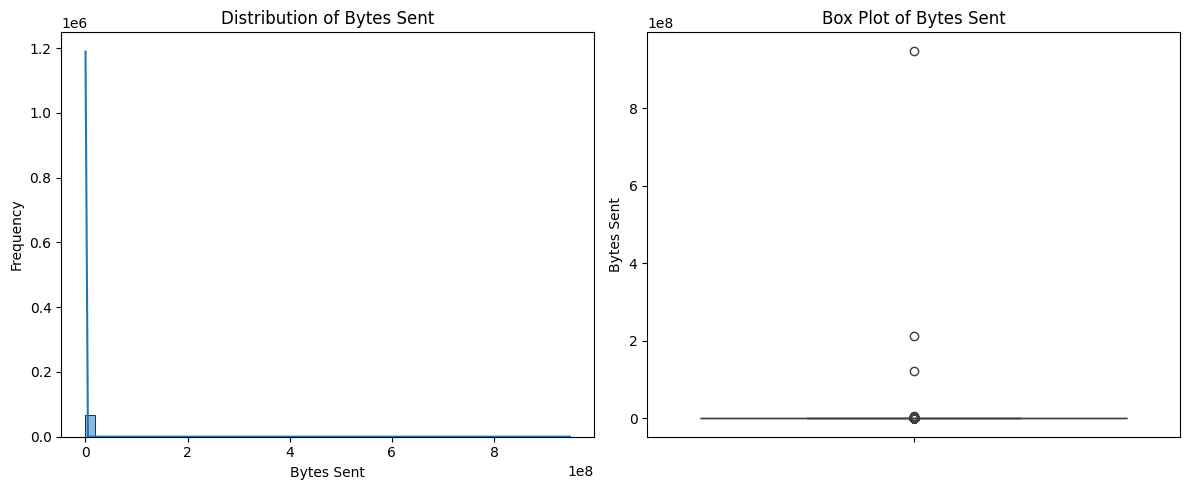

-------------------------------------------------------------

Descriptive Statistics for 'Bytes Received':
count    6.553200e+04
mean     7.473815e+04
std      2.463208e+06
min      0.000000e+00
25%      0.000000e+00
50%      7.900000e+01
75%      4.490000e+02
max      3.208818e+08
Name: Bytes Received, dtype: float64


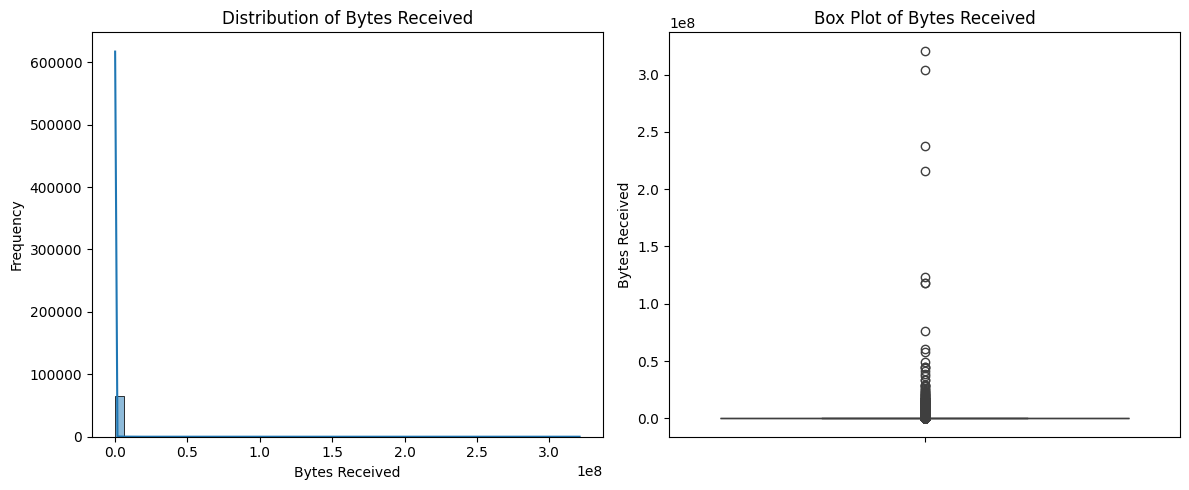

-------------------------------------------------------------

Descriptive Statistics for 'Packets':
count    6.553200e+04
mean     1.028660e+02
std      5.133002e+03
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      6.000000e+00
max      1.036116e+06
Name: Packets, dtype: float64


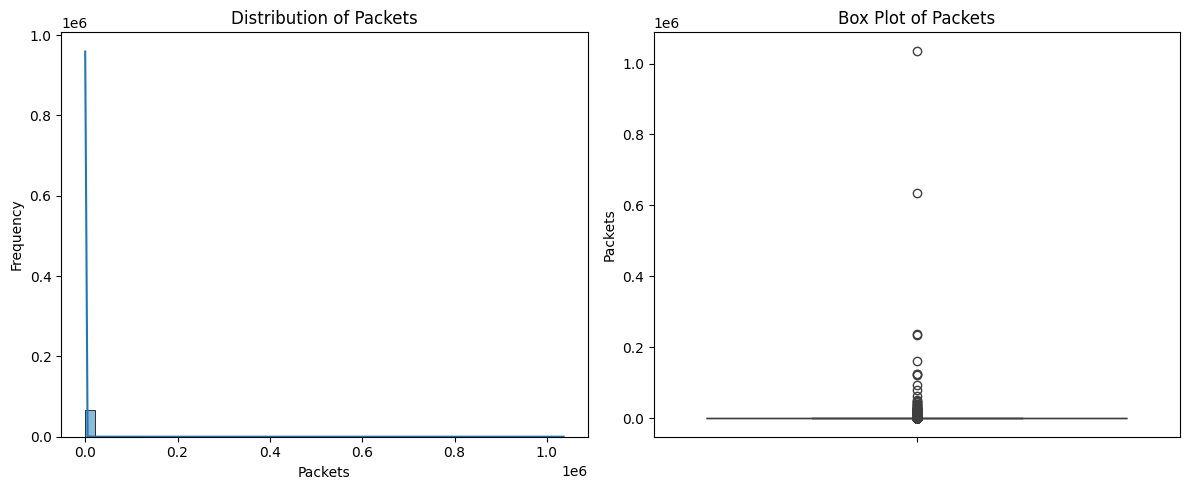

-------------------------------------------------------------

Descriptive Statistics for 'Elapsed Time (sec)':
count    65532.000000
mean        65.833577
std        302.461762
min          0.000000
25%          0.000000
50%         15.000000
75%         30.000000
max      10824.000000
Name: Elapsed Time (sec), dtype: float64


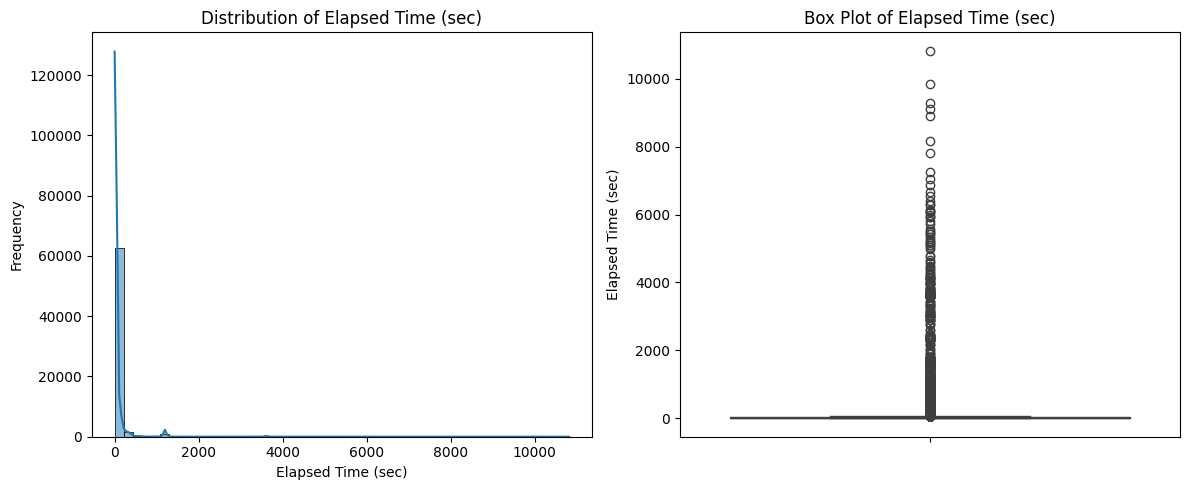

-------------------------------------------------------------

Descriptive Statistics for 'pkts_sent':
count     65532.000000
mean         41.399530
std        3218.871288
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max      747520.000000
Name: pkts_sent, dtype: float64


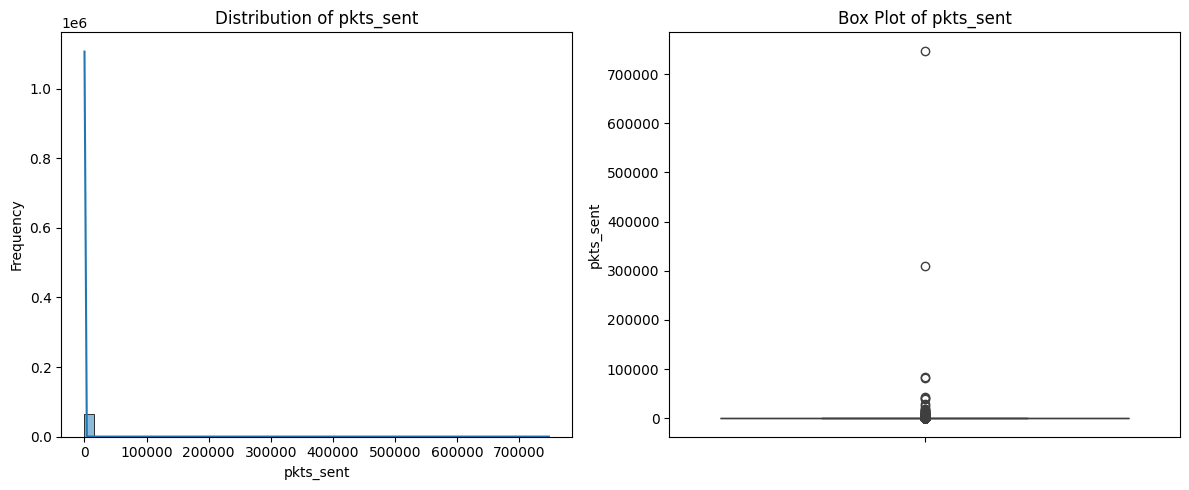

-------------------------------------------------------------

Descriptive Statistics for 'pkts_received':
count     65532.000000
mean         61.466505
std        2223.332271
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max      327208.000000
Name: pkts_received, dtype: float64


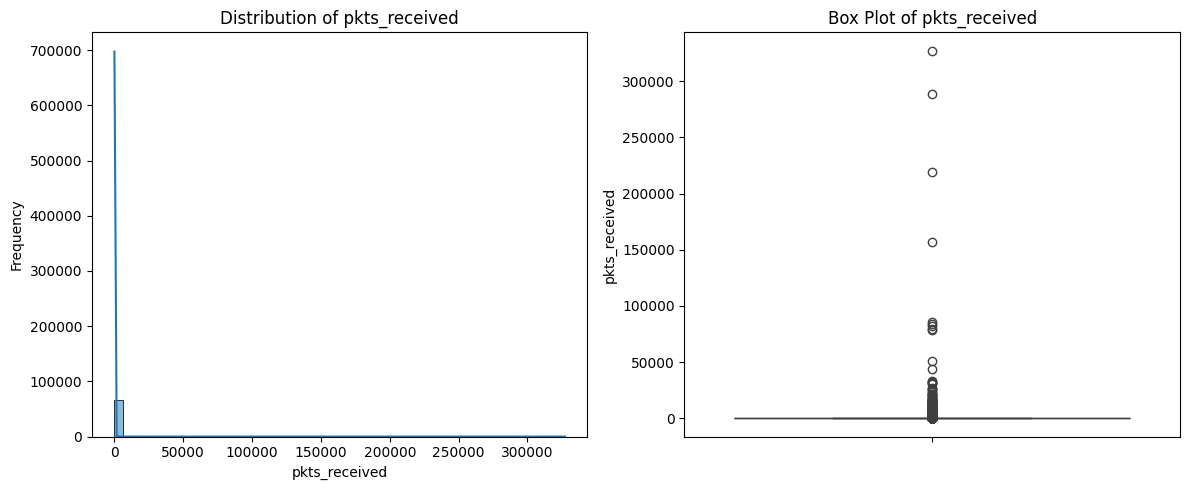

-------------------------------------------------------------


In [38]:
def analyze_numerical_features(df, numerical_cols):
    for col in numerical_cols:
        
        print(f"\nDescriptive Statistics for '{col}':")
        print(df[col].describe())

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        sns.histplot(df[col], kde=True, bins=50)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')

        plt.subplot(1, 2, 2)
        sns.boxplot(y=df[col])
        plt.title(f'Box Plot of {col}')
        plt.ylabel(col)

        plt.tight_layout()
        plt.show()

        print("-------------------------------------------------------------")
        
analyze_numerical_features(df, numerical_cols)


--- Categorical vs. Numerical Relationships ---

Distribution of Bytes by Action:


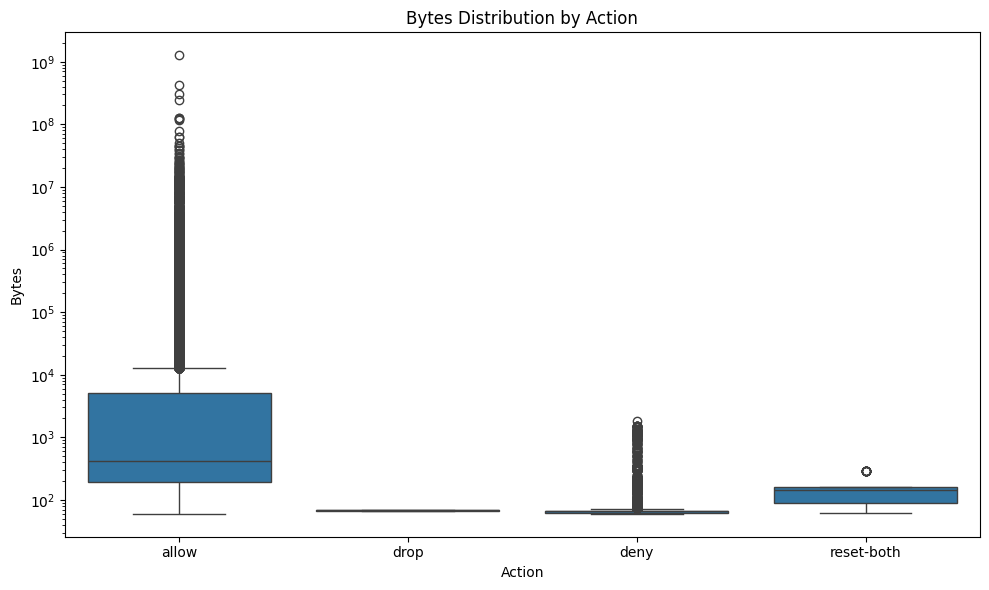

              count           mean           std   min     25%    50%     75%  \
Action                                                                          
allow       37640.0  169037.953241  7.412625e+06  60.0  194.00  422.0  5166.0   
deny        14987.0      83.211717  8.857610e+01  60.0   62.00   66.0    66.0   
drop        12851.0      68.675278  1.882625e+00  66.0   66.00   70.0    70.0   
reset-both     54.0     157.351852  8.132399e+01  62.0   88.75  145.0   158.5   

                     max  
Action                    
allow       1.269359e+09  
deny        1.850000e+03  
drop        7.000000e+01  
reset-both  2.930000e+02  

Distribution of Packets by Action:


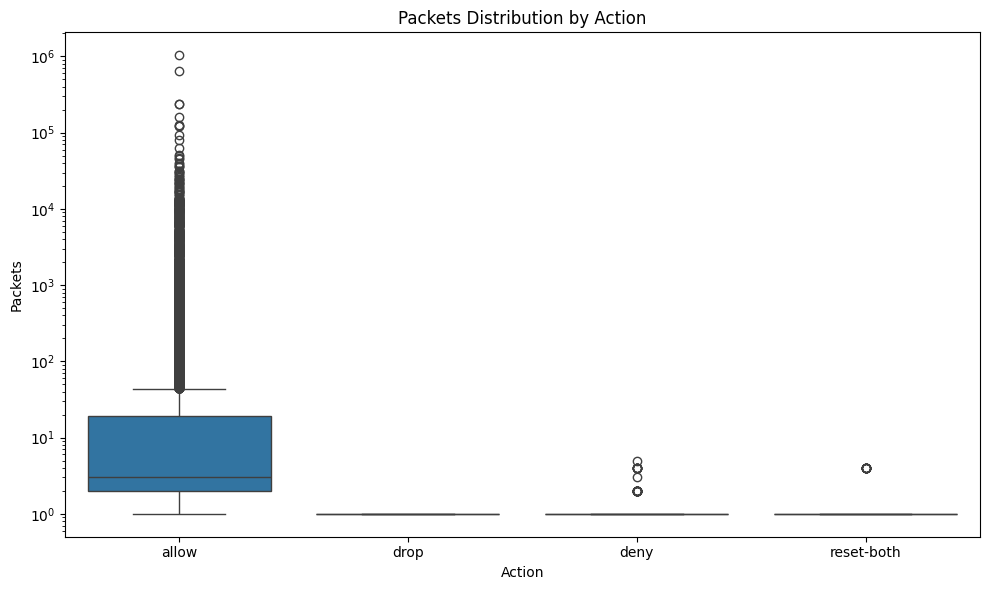

              count        mean          std  min  25%  50%   75%        max
Action                                                                      
allow       37640.0  178.348565  6771.929736  1.0  2.0  3.0  19.0  1036116.0
deny        14987.0    1.003270     0.083641  1.0  1.0  1.0   1.0        5.0
drop        12851.0    1.000000     0.000000  1.0  1.0  1.0   1.0        1.0
reset-both     54.0    1.666667     1.258930  1.0  1.0  1.0   1.0        4.0

Distribution of Elapsed Time (sec) by Action:


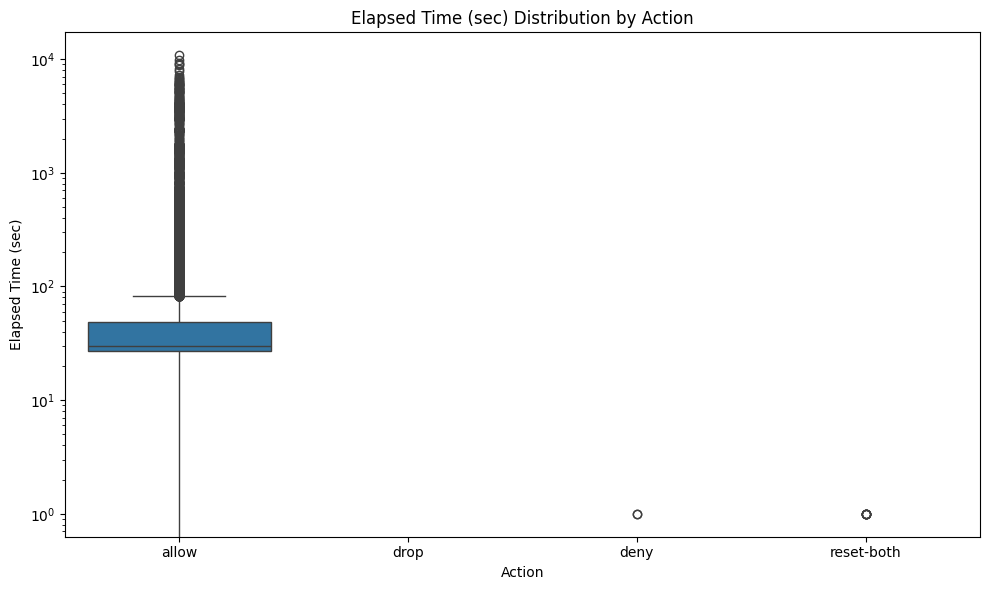

              count        mean         std  min   25%   50%   75%      max
Action                                                                     
allow       37640.0  114.617349  392.025709  0.0  27.0  30.0  49.0  10824.0
deny        14987.0    0.000133    0.011552  0.0   0.0   0.0   0.0      1.0
drop        12851.0    0.000000    0.000000  0.0   0.0   0.0   0.0      0.0
reset-both     54.0    0.129630    0.339050  0.0   0.0   0.0   0.0      1.0

--- Numerical vs. Numerical Relationships ---

Correlation Matrix of Numerical Features:
                       Bytes  Bytes Sent  Bytes Received   Packets  \
Bytes               1.000000    0.933462        0.830225  0.974379   
Bytes Sent          0.933462    1.000000        0.575047  0.887596   
Bytes Received      0.830225    0.575047        1.000000  0.843067   
Packets             0.974379    0.887596        0.843067  1.000000   
Elapsed Time (sec)  0.148834    0.126039        0.143601  0.147074   
pkts_sent           0.966548    0.

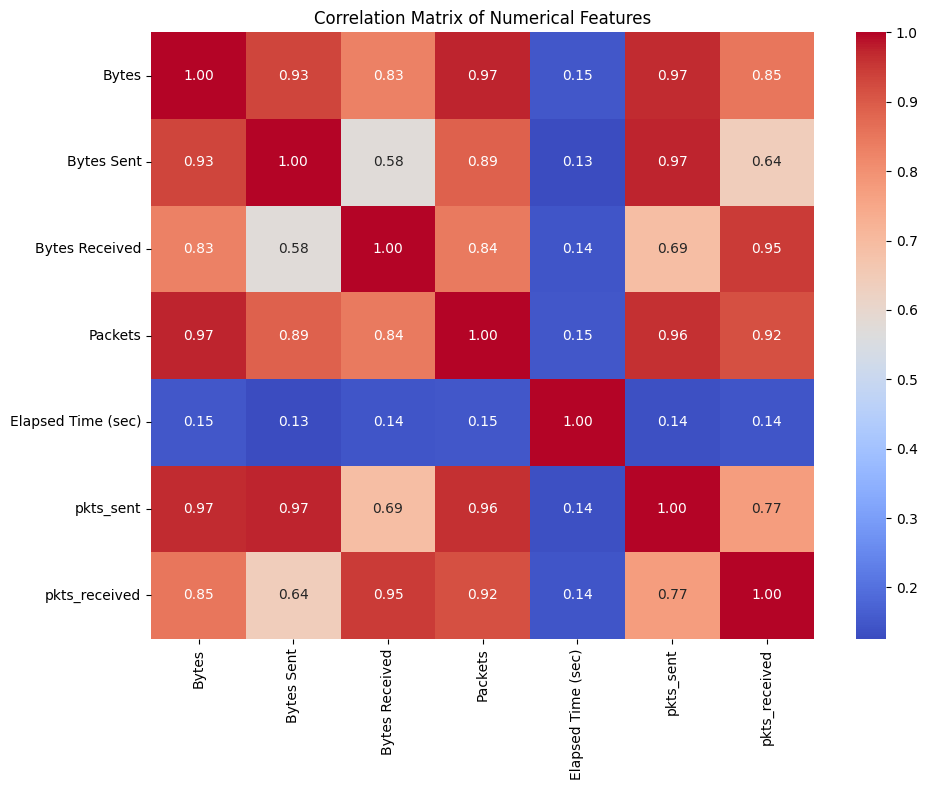

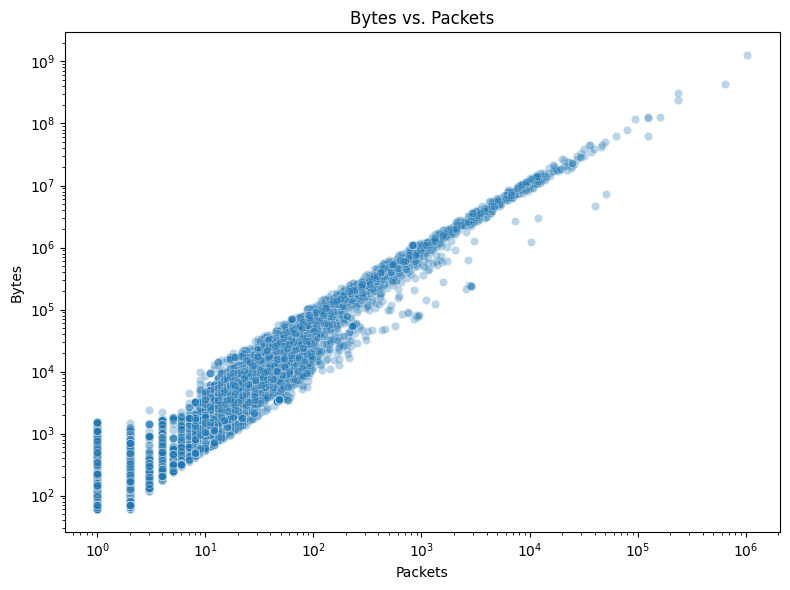

In [40]:
def analyze_bivariate_relationships(df, numerical_cols, categorical_cols):
    # Categorical vs. Numerical
    print("\n--- Categorical vs. Numerical Relationships ---")
    if 'Action' in categorical_cols:
        numerical_metrics = ['Bytes', 'Packets', 'Elapsed Time (sec)']
        for num_col in numerical_metrics:
            if num_col in numerical_cols:
                print(f"\nDistribution of {num_col} by Action:")
                plt.figure(figsize=(10, 6))
                sns.boxplot(data=df, x='Action', y=num_col)
                plt.title(f'{num_col} Distribution by Action')
                plt.xlabel('Action')
                plt.ylabel(num_col)
                plt.yscale('log')
                plt.tight_layout()
                plt.show()

                print(df.groupby('Action')[num_col].describe())

    # Numerical vs. Numerical
    print("\n--- Numerical vs. Numerical Relationships ---")
    true_numerical_cols = [
        'Bytes', 'Bytes Sent', 'Bytes Received',
        'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received'
    ]
    true_numerical_cols = [col for col in true_numerical_cols if col in df.columns]

    if len(true_numerical_cols) > 1:
        print("\nCorrelation Matrix of Numerical Features:")
        correlation_matrix = df[true_numerical_cols].corr()
        print(correlation_matrix)

        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title('Correlation Matrix of Numerical Features')
        plt.tight_layout()
        plt.show()

        # Scatter plots for key relationships (e.g., Bytes vs Packets)
        if 'Bytes' in true_numerical_cols and 'Packets' in true_numerical_cols:
            plt.figure(figsize=(8, 6))
            sns.scatterplot(data=df, x='Packets', y='Bytes', alpha=0.3)
            plt.title('Bytes vs. Packets')
            plt.xlabel('Packets')
            plt.ylabel('Bytes')
            plt.xscale('log')
            plt.yscale('log')
            plt.tight_layout()
            plt.show()
    else:
        print("Not enough numerical columns to compute a correlation matrix or scatter plots.")


analyze_bivariate_relationships(df, numerical_cols, categorical_cols)

In [41]:
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


Created synthetic column of timestamp because of the "real-time" focus on the project's description


Analyzing 'Elapsed Time (sec)' distribution:
count    65532.000000
mean        65.833577
std        302.461762
min          0.000000
25%          0.000000
50%         15.000000
75%         30.000000
max      10824.000000
Name: Elapsed Time (sec), dtype: float64


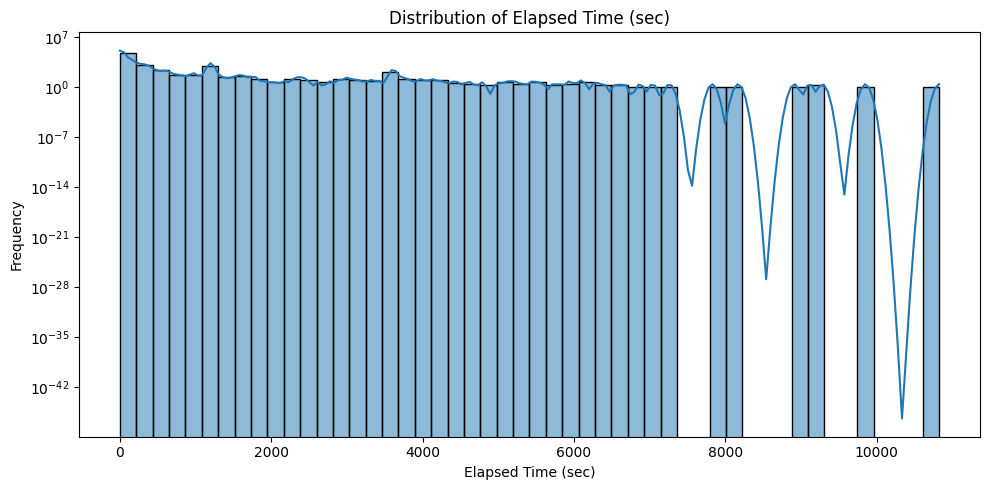

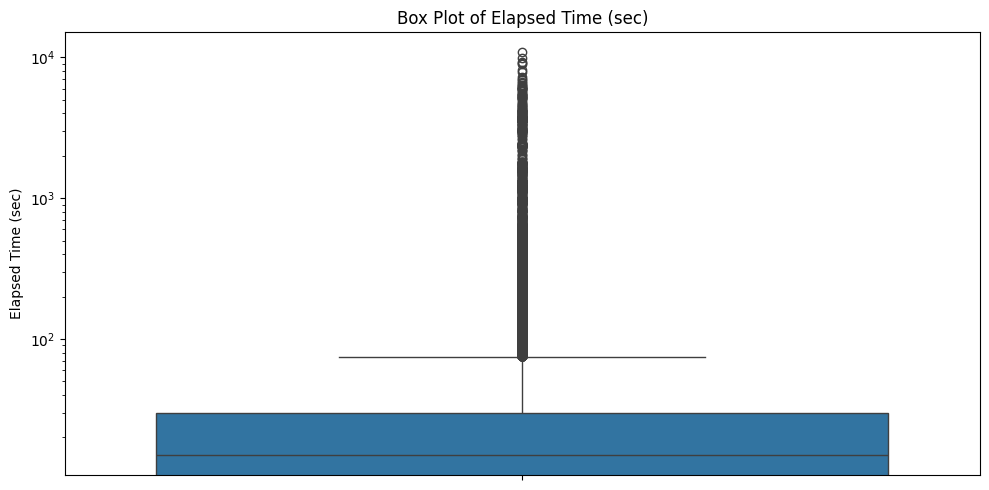


Synthesizing 'Timestamp' column. Simulating 65532 logs over 7 days.

First 5 rows with new 'Timestamp' column:
                   Timestamp  Elapsed Time (sec)  Bytes
0 2025-01-01 00:00:00.000000                  30    177
1 2025-01-01 00:00:09.229079                  17   4768
2 2025-01-01 00:00:18.458158                1199    238
3 2025-01-01 00:00:27.687237                  17   3327
4 2025-01-01 00:00:36.916316                  16  25358

Last 5 rows with new 'Timestamp' column:
                       Timestamp  Elapsed Time (sec)    Bytes
65527 2025-01-07 23:59:13.859633                  15      314
65528 2025-01-07 23:59:23.088712                  77  4680740
65529 2025-01-07 23:59:32.317791                   0       70
65530 2025-01-07 23:59:41.546870                   0       70
65531 2025-01-07 23:59:50.775949                   0       70

--- Engineering New Features ---
Engineered 'Avg_Packet_Size'
Engineered 'Bytes_Per_Sec'
Engineered 'Packets_Per_Sec'
Engineered 'Bytes_S

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,Timestamp,Avg_Packet_Size,Bytes_Per_Sec,Packets_Per_Sec,Bytes_Sent_Ratio,Unidir_Outbound_Flag,Packets_Sent_Ratio,Unidir_Outbound_Pkts_Flag
0,57222,53,54587,53,allow,177,94,83,2,30,1,1,2025-01-01 00:00:00.000000,88.500000,5.900000,0.066667,1.132530,0,1.000000,0
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9,2025-01-01 00:00:09.229079,250.947368,280.470588,1.117647,0.505051,0,1.111111,0
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1,2025-01-01 00:00:18.458158,119.000000,0.198499,0.001668,0.983333,0,1.000000,0
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7,2025-01-01 00:00:27.687237,221.800000,195.705882,0.882353,0.761249,0,1.142857,0
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18,2025-01-01 00:00:36.916316,818.000000,1584.875000,1.937500,0.364801,0,0.722222,0


In [48]:
def time_series_and_feature_engineering(df):
    if 'Elapsed Time (sec)' in df.columns:
        print("\nAnalyzing 'Elapsed Time (sec)' distribution:")
        print(df['Elapsed Time (sec)'].describe())
        plt.figure(figsize=(10, 5))
        sns.histplot(df['Elapsed Time (sec)'], bins=50, kde=True)
        plt.title('Distribution of Elapsed Time (sec)')
        plt.xlabel('Elapsed Time (sec)')
        plt.ylabel('Frequency')
        plt.yscale('log')
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 5))
        sns.boxplot(y=df['Elapsed Time (sec)'])
        plt.title('Box Plot of Elapsed Time (sec)')
        plt.ylabel('Elapsed Time (sec)')
        plt.yscale('log')
        plt.tight_layout()
        plt.show()

    total_entries = len(df)
    start_date = datetime(2025, 1, 1, 0, 0, 0)

    # 7 days
    time_increment_per_log = timedelta(seconds=7 * 24 * 3600 / total_entries)

    print(f"\nSynthesizing 'Timestamp' column. Simulating {total_entries} logs over 7 days.")
    df['Timestamp'] = [start_date + i * time_increment_per_log for i in range(total_entries)]
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])

    print("\nFirst 5 rows with new 'Timestamp' column:")
    print(df[['Timestamp', 'Elapsed Time (sec)', 'Bytes']].head())
    print("\nLast 5 rows with new 'Timestamp' column:")
    print(df[['Timestamp', 'Elapsed Time (sec)', 'Bytes']].tail())


    print("\n--- Engineering New Features ---")

    df['Elapsed Time (sec)_safe'] = df['Elapsed Time (sec)'].replace(0, 1) # Replace 0 with 1 to avoid /0 for rates
    df['Packets_safe'] = df['Packets'].replace(0, 1) # Replace 0 with 1 for avg_packet_size
    df['Bytes_safe'] = df['Bytes'].replace(0, 1) # Replace 0 with 1 for packet_size

    # Average Packet Size (Bytes / Packets)
    df['Avg_Packet_Size'] = df['Bytes'] / df['Packets_safe']
    # If Bytes is 0, Avg_Packet_Size should be 0
    df.loc[df['Bytes'] == 0, 'Avg_Packet_Size'] = 0
    print("Engineered 'Avg_Packet_Size'")

    # Bytes per Second (Bandwidth)
    df['Bytes_Per_Sec'] = df['Bytes'] / df['Elapsed Time (sec)_safe']
    print("Engineered 'Bytes_Per_Sec'")

    # Packets per Second (Packet Rate)
    df['Packets_Per_Sec'] = df['Packets'] / df['Elapsed Time (sec)_safe']
    print("Engineered 'Packets_Per_Sec'")

    # Ratio of Sent vs. Received Bytes
    df['Bytes_Received_safe'] = df['Bytes Received'].replace(0, 1)
    df['Bytes_Sent_Ratio'] = df['Bytes Sent'] / df['Bytes_Received_safe']

    df.loc[(df['Bytes Received'] == 0) & (df['Bytes Sent'] == 0), 'Bytes_Sent_Ratio'] = 0
    df.loc[(df['Bytes Received'] == 0) & (df['Bytes Sent'] > 0), 'Bytes_Sent_Ratio'] = df['Bytes Sent'] # Represent as sent bytes if received is 0
    # Add a flag for 'Unidirectional Outbound' or 'Scanning behavior'
    df['Unidir_Outbound_Flag'] = ((df['Bytes Received'] == 0) & (df['Bytes Sent'] > 0)).astype(int)
    print("Engineered 'Bytes_Sent_Ratio' and 'Unidir_Outbound_Flag'")

    # Ratio of Sent vs. Received Packets
    df['pkts_received_safe'] = df['pkts_received'].replace(0, 1)
    df['Packets_Sent_Ratio'] = df['pkts_sent'] / df['pkts_received_safe']
    df.loc[(df['pkts_received'] == 0) & (df['pkts_sent'] == 0), 'Packets_Sent_Ratio'] = 0
    df.loc[(df['pkts_received'] == 0) & (df['pkts_sent'] > 0), 'Packets_Sent_Ratio'] = df['pkts_sent'] # Represent as sent pkts if received is 0
    df['Unidir_Outbound_Pkts_Flag'] = ((df['pkts_received'] == 0) & (df['pkts_sent'] > 0)).astype(int)
    print("Engineered 'Packets_Sent_Ratio' and 'Unidir_Outbound_Pkts_Flag'")

    df = df.drop(columns=['Elapsed Time (sec)_safe', 'Packets_safe', 'Bytes_safe',
                          'Bytes_Received_safe', 'pkts_received_safe'])

    print("\n--- First 5 rows with new engineered features ---")
    print(df[['Timestamp', 'Bytes', 'Packets', 'Avg_Packet_Size', 'Bytes_Per_Sec', 'Packets_Per_Sec', 'Bytes Sent', 'Bytes Received', 'Bytes_Sent_Ratio', 'Unidir_Outbound_Flag']].head())

    return df

df_engineered = time_series_and_feature_engineering(df.copy())
df_engineered.head()

### Threat and Anomaly Detection System

In [51]:
def train_anomaly_detector(df_engineered):
    features_to_use = [
        'Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)',
        'pkts_sent', 'pkts_received',
        'Avg_Packet_Size', 'Bytes_Per_Sec', 'Packets_Per_Sec',
        'Bytes_Sent_Ratio', 'Unidir_Outbound_Flag', 'Packets_Sent_Ratio', 'Unidir_Outbound_Pkts_Flag'
    ]

    if 'Action' in df_engineered.columns:
        features_to_use.append('Action')

    features_to_use = [col for col in features_to_use if col in df_engineered.columns]

    print(f"\nFeatures selected for anomaly detection: {features_to_use}")

    model_numerical_cols = []
    model_categorical_cols = []
    temp_df = df_engineered[features_to_use].copy()

    for col in temp_df.columns:
        if pd.api.types.is_numeric_dtype(temp_df[col]):
            model_numerical_cols.append(col)
        elif pd.api.types.is_object_dtype(temp_df[col]) or pd.api.types.is_string_dtype(temp_df[col]):
            model_categorical_cols.append(col)

    print(f"Numerical features for model: {model_numerical_cols}")
    print(f"Categorical features for model: {model_categorical_cols}")

    # --- Preprocessing ---
    # Handle Categorical Features: One-Hot Encoding for 'Action'
    if model_categorical_cols:
        print("\nApplying One-Hot Encoding to categorical features...")
        temp_df = pd.get_dummies(temp_df, columns=model_categorical_cols, drop_first=True, dtype=int)
        print("Categorical features encoded.")
        print(f"New columns after encoding: {temp_df.columns.tolist()}")

    # Feature Scaling for Numerical Features
    print("\nApplying StandardScaler to numerical features...")
    scaler = StandardScaler()
    
    cols_to_scale = [col for col in temp_df.columns if pd.api.types.is_numeric_dtype(temp_df[col])]
    temp_df[cols_to_scale] = scaler.fit_transform(temp_df[cols_to_scale])
    print("Numerical features scaled.")

    preprocessor = {'scaler': scaler, 'features_after_encoding': temp_df.columns.tolist()}


    # Anomaly Detection Model: Isolation Forest
    print("\nTraining Isolation Forest model...")

    contamination_rate = 0.01 # Assume 1% of data are anomalies
    model = IsolationForest(n_estimators=100, contamination=contamination_rate, random_state=42, n_jobs=-1)

    model.fit(temp_df)
    print("Isolation Forest model trained.")


    df_engineered['anomaly_score'] = model.decision_function(temp_df)
    df_engineered['anomaly_label'] = model.predict(temp_df) # -1 is anomaly, 1 is normal

    print("\nAnomaly Detection Results (First 10 records):")
    print(df_engineered[['Timestamp', 'Action', 'Bytes', 'Packets', 'anomaly_score', 'anomaly_label']].head(10))
    print("\nNumber of anomalies detected (-1):", (df_engineered['anomaly_label'] == -1).sum())
    print("Number of normal instances detected (1):", (df_engineered['anomaly_label'] == 1).sum())

    joblib.dump(model, 'isolation_forest_model.pkl')
    joblib.dump(preprocessor, 'data_preprocessor.pkl')
    print("\nModel and preprocessor saved.")

    return model, preprocessor, features_to_use, df_engineered


trained_model, preprocessor, features_used, df_with_anomalies = train_anomaly_detector(df_engineered)


Features selected for anomaly detection: ['Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received', 'Avg_Packet_Size', 'Bytes_Per_Sec', 'Packets_Per_Sec', 'Bytes_Sent_Ratio', 'Unidir_Outbound_Flag', 'Packets_Sent_Ratio', 'Unidir_Outbound_Pkts_Flag', 'Action']
Numerical features for model: ['Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received', 'Avg_Packet_Size', 'Bytes_Per_Sec', 'Packets_Per_Sec', 'Bytes_Sent_Ratio', 'Unidir_Outbound_Flag', 'Packets_Sent_Ratio', 'Unidir_Outbound_Pkts_Flag']
Categorical features for model: ['Action']

Applying One-Hot Encoding to categorical features...
Categorical features encoded.
New columns after encoding: ['Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received', 'Avg_Packet_Size', 'Bytes_Per_Sec', 'Packets_Per_Sec', 'Bytes_Sent_Ratio', 'Unidir_Outbound_Flag', 'Packets_Sent_Ratio', 'Unidir_Outbound_Pkts_Flag'


Anomaly Score Distribution:


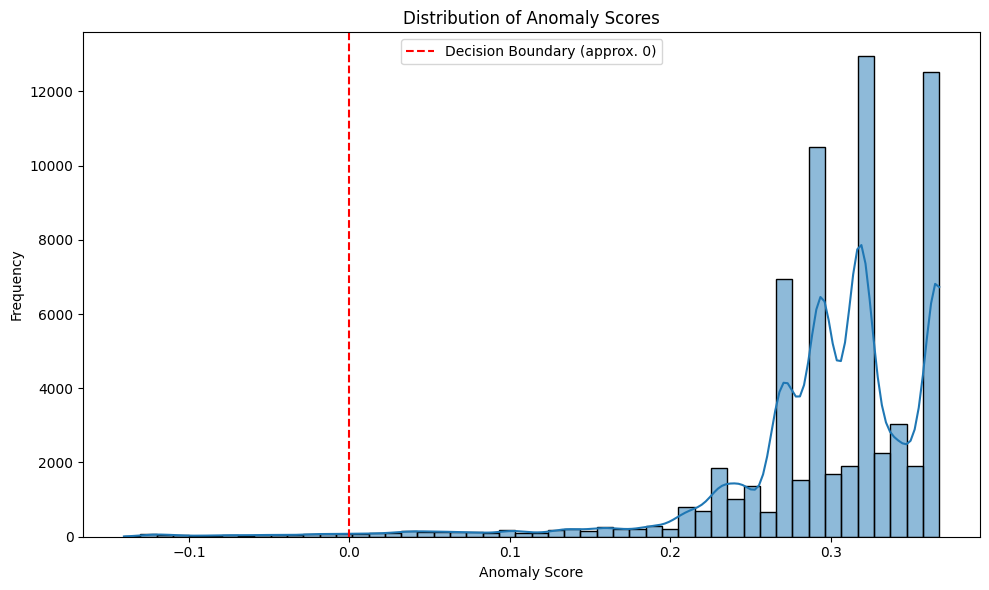

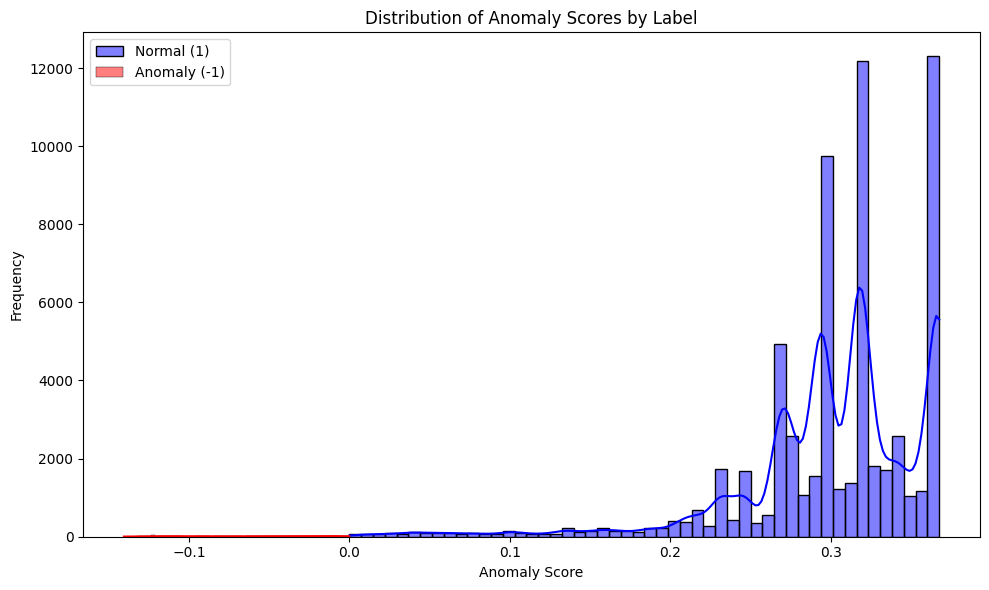


Interpretation of Anomaly Scores:
Scores closer to 0 (or negative values) indicate higher anomaly likelihood. Positive scores indicate normality.
The model detected 656 anomalies out of 65532 records.

Inspecting Top Anomalies (Records with Lowest Anomaly Scores):

Top 20 Most Anomalous Records:
                       Timestamp  Source Port  Destination Port Action       Bytes  Packets  Elapsed Time (sec)  Bytes_Per_Sec  Packets_Per_Sec  Bytes_Sent_Ratio  Unidir_Outbound_Flag  anomaly_score  anomaly_label
10220 2025-01-02 02:12:01.187380        57235             15187  allow  1269359015  1036116                9283  136740.171819       111.614349          2.955846                     0      -0.140486             -1
61429 2025-01-07 13:28:53.093891        15792              3478  allow   428935914   635946                2242  191318.427297       283.651204          0.990493                     0      -0.137188             -1
40689 2025-01-05 08:18:41.995431        59275               

In [55]:
def evaluate_and_improve_anomaly_detection(df_with_anomalies):
    print("\nAnomaly Score Distribution:")
    plt.figure(figsize=(10, 6))
    sns.histplot(df_with_anomalies['anomaly_score'], bins=50, kde=True)
    plt.title('Distribution of Anomaly Scores')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Frequency')
    plt.axvline(x=0, color='r', linestyle='--', label='Decision Boundary (approx. 0)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.histplot(df_with_anomalies[df_with_anomalies['anomaly_label'] == 1]['anomaly_score'], color='blue', label='Normal (1)', kde=True, bins=50)
    sns.histplot(df_with_anomalies[df_with_anomalies['anomaly_label'] == -1]['anomaly_score'], color='red', label='Anomaly (-1)', kde=True, bins=50)
    plt.title('Distribution of Anomaly Scores by Label')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\nInterpretation of Anomaly Scores:")
    print("Scores closer to 0 (or negative values) indicate higher anomaly likelihood. Positive scores indicate normality.")
    print(f"The model detected {len(df_with_anomalies[df_with_anomalies['anomaly_label'] == -1])} anomalies out of {len(df_with_anomalies)} records.")

    print("\nInspecting Top Anomalies (Records with Lowest Anomaly Scores):")
    top_anomalies = df_with_anomalies.sort_values(by='anomaly_score').head(20)
    print("\nTop 20 Most Anomalous Records:")
    display_cols = ['Timestamp', 'Source Port', 'Destination Port', 'Action', 'Bytes',
                    'Packets', 'Elapsed Time (sec)', 'Bytes_Per_Sec', 'Packets_Per_Sec',
                    'Bytes_Sent_Ratio', 'Unidir_Outbound_Flag', 'anomaly_score', 'anomaly_label']
    display_cols = [col for col in display_cols if col in top_anomalies.columns]
    print(top_anomalies[display_cols].to_string())

evaluate_and_improve_anomaly_detection(df_with_anomalies)

Key characteristics to look for in top anomalies:
- Extremely high/low Bytes, Packets, or Elapsed Time (sec).
- Unusual Bytes_Per_Sec or Packets_Per_Sec (e.g., very high for floods, very low for stealthy comms).
- High Bytes_Sent_Ratio or Unidir_Outbound_Flag (potential scanning, exfiltration).
- Rare Source/Destination Ports or unusual Action for a given port.

### Dashboard


Aggregating data for Hourly timeframe (H)...


C:\Users\khand\AppData\Local\Temp\ipykernel_17692\2510600763.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  traffic_summary = df_dashboard['Bytes'].resample(freq).sum().fillna(0)
C:\Users\khand\AppData\Local\Temp\ipykernel_17692\2510600763.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  errors_summary = df_dashboard['is_error'].resample(freq).sum().fillna(0)
C:\Users\khand\AppData\Local\Temp\ipykernel_17692\2510600763.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  threats_summary = df_dashboard['is_threat_anomaly'].resample(freq).sum().fillna(0)


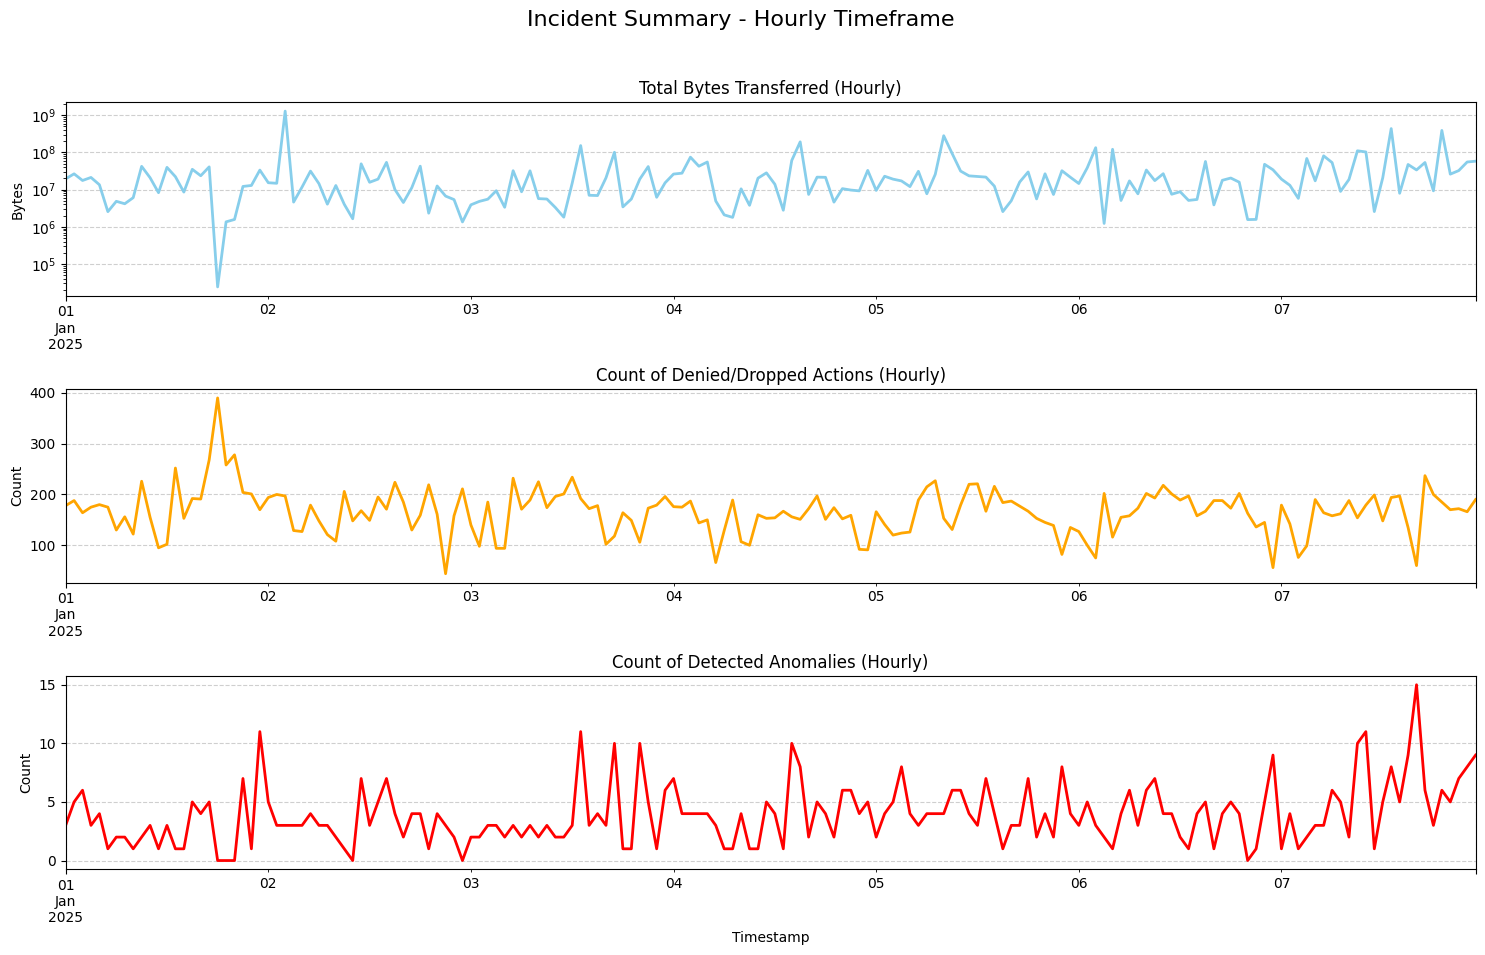


Aggregating data for 12 Hours timeframe (12H)...


C:\Users\khand\AppData\Local\Temp\ipykernel_17692\2510600763.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  traffic_summary = df_dashboard['Bytes'].resample(freq).sum().fillna(0)
C:\Users\khand\AppData\Local\Temp\ipykernel_17692\2510600763.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  errors_summary = df_dashboard['is_error'].resample(freq).sum().fillna(0)
C:\Users\khand\AppData\Local\Temp\ipykernel_17692\2510600763.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  threats_summary = df_dashboard['is_threat_anomaly'].resample(freq).sum().fillna(0)


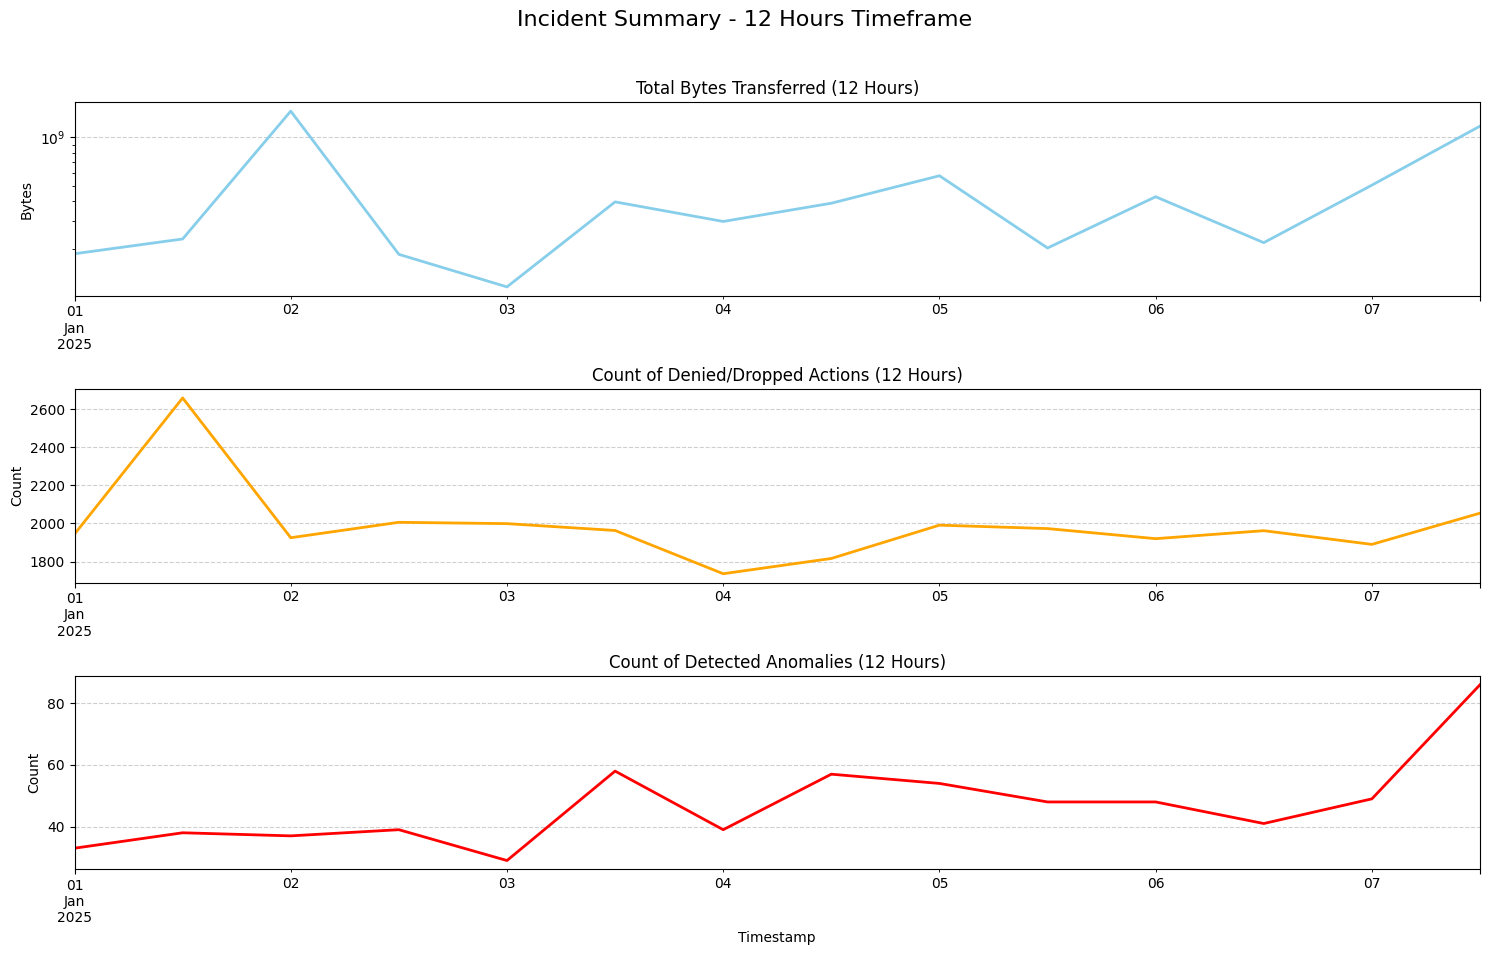


Aggregating data for 24 Hours timeframe (24H)...


C:\Users\khand\AppData\Local\Temp\ipykernel_17692\2510600763.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  traffic_summary = df_dashboard['Bytes'].resample(freq).sum().fillna(0)
C:\Users\khand\AppData\Local\Temp\ipykernel_17692\2510600763.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  errors_summary = df_dashboard['is_error'].resample(freq).sum().fillna(0)
C:\Users\khand\AppData\Local\Temp\ipykernel_17692\2510600763.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  threats_summary = df_dashboard['is_threat_anomaly'].resample(freq).sum().fillna(0)


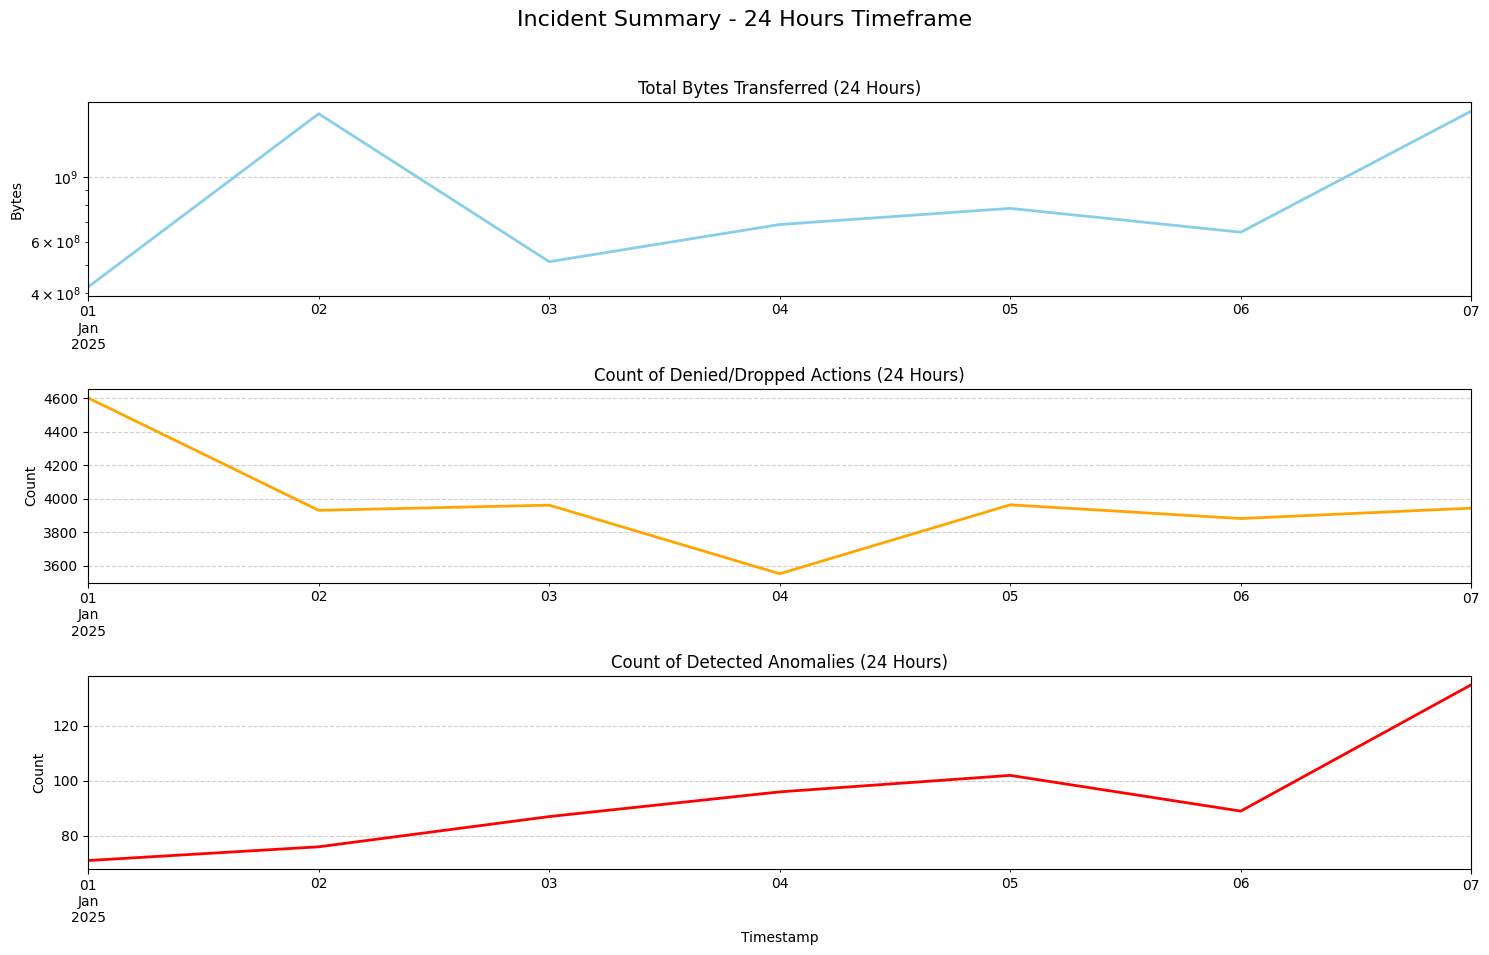


--- Additional Dashboard Insights ---


C:\Users\khand\AppData\Local\Temp\ipykernel_17692\2510600763.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=denied_dropped_ports.values, y=denied_dropped_ports.index.astype(str), palette='viridis')


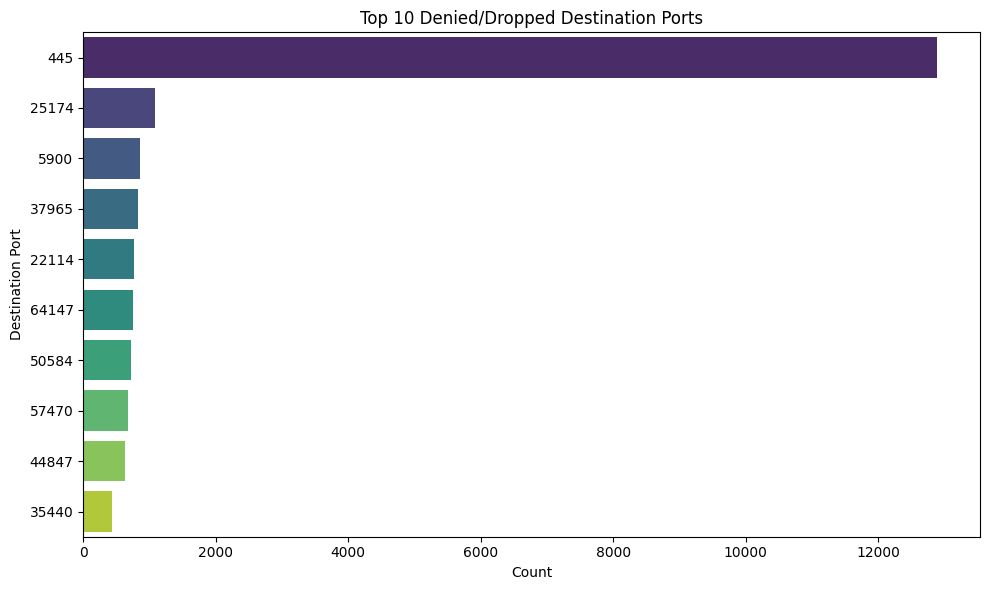

C:\Users\khand\AppData\Local\Temp\ipykernel_17692\2510600763.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=anomaly_dest_ports.values, y=anomaly_dest_ports.index.astype(str), palette='magma')


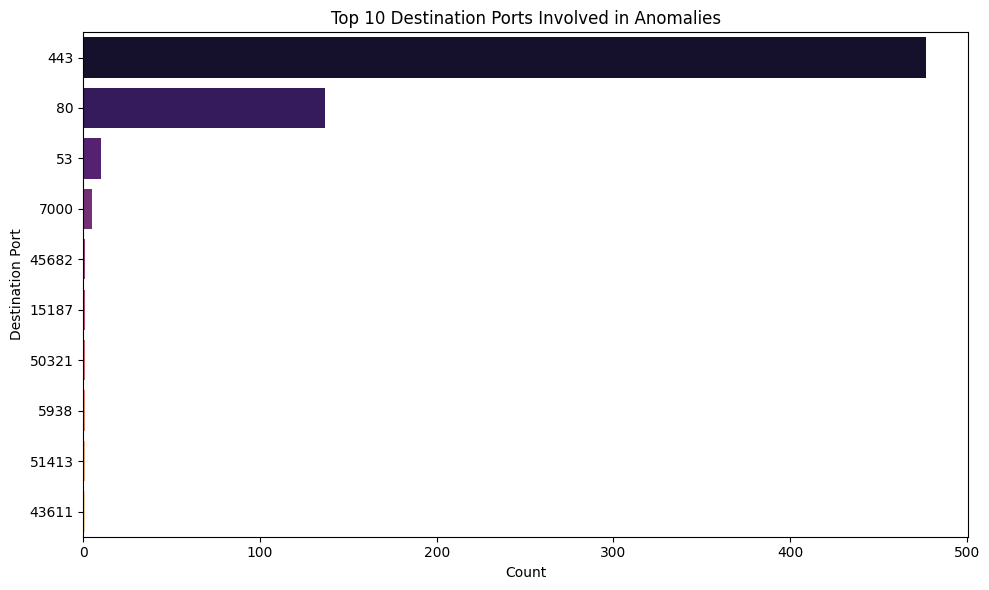


Dashboard creation complete. Review the generated plots for insights into security incidents.


In [56]:
def create_reporting_dashboard(df_with_anomalies):
    df_dashboard = df_with_anomalies.set_index('Timestamp').sort_index()

    df_dashboard['is_error'] = df_dashboard['Action'].isin(['deny', 'drop']).astype(int)
    df_dashboard['is_threat_anomaly'] = (df_dashboard['anomaly_label'] == -1).astype(int)


    timeframes = {'Hourly': 'H', '12 Hours': '12H', '24 Hours': '24H'}
    fig_count = 1

    for name, freq in timeframes.items():
        print(f"\nAggregating data for {name} timeframe ({freq})...")

        # Total Traffic (Bytes)
        traffic_summary = df_dashboard['Bytes'].resample(freq).sum().fillna(0)
        # Errors (Deny/Drop Actions)
        errors_summary = df_dashboard['is_error'].resample(freq).sum().fillna(0)
        # Threats/Anomalies
        threats_summary = df_dashboard['is_threat_anomaly'].resample(freq).sum().fillna(0)


        plt.figure(figsize=(15, 10))
        plt.suptitle(f'Incident Summary - {name} Timeframe', fontsize=16)

        # Plot 1: Total Traffic (Bytes)
        plt.subplot(3, 1, 1)
        traffic_summary.plot(kind='line', ax=plt.gca(), color='skyblue', linewidth=2)
        plt.title(f'Total Bytes Transferred ({name})')
        plt.ylabel('Bytes')
        plt.xlabel('')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.ticklabel_format(style='plain', axis='y')
        plt.yscale('log')

        # Plot 2: Error Actions (Deny/Drop)
        plt.subplot(3, 1, 2)
        errors_summary.plot(kind='line', ax=plt.gca(), color='orange', linewidth=2)
        plt.title(f'Count of Denied/Dropped Actions ({name})')
        plt.ylabel('Count')
        plt.xlabel('')
        plt.grid(True, linestyle='--', alpha=0.6)

        # Plot 3: Detected Threats/Anomalies
        plt.subplot(3, 1, 3)
        threats_summary.plot(kind='line', ax=plt.gca(), color='red', linewidth=2)
        plt.title(f'Count of Detected Anomalies ({name})')
        plt.ylabel('Count')
        plt.xlabel('Timestamp')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout(rect=[0, 0.03, 1, 0.96])
        plt.show()

    print("\n--- Additional Dashboard Insights ---")

    # 1. Top 10 Most Frequent Denied/Dropped Destination Ports
    denied_dropped_ports = df_dashboard[df_dashboard['is_error'] == 1]['Destination Port'].value_counts().head(10)
    if not denied_dropped_ports.empty:
        plt.figure(figsize=(10, 6))
        sns.barplot(x=denied_dropped_ports.values, y=denied_dropped_ports.index.astype(str), palette='viridis')
        plt.title('Top 10 Denied/Dropped Destination Ports')
        plt.xlabel('Count')
        plt.ylabel('Destination Port')
        plt.tight_layout()
        plt.show()
    else:
        print("No denied/dropped ports to display.")

    # 2. Top 10 Most Frequent Destination Ports in Anomalies
    anomaly_dest_ports = df_dashboard[df_dashboard['is_threat_anomaly'] == 1]['Destination Port'].value_counts().head(10)
    if not anomaly_dest_ports.empty:
        plt.figure(figsize=(10, 6))
        sns.barplot(x=anomaly_dest_ports.values, y=anomaly_dest_ports.index.astype(str), palette='magma')
        plt.title('Top 10 Destination Ports Involved in Anomalies')
        plt.xlabel('Count')
        plt.ylabel('Destination Port')
        plt.tight_layout()
        plt.show()
    else:
        print("No anomalous ports to display.")

    print("\nDashboard creation complete. Review the generated plots for insights into security incidents.")
    

create_reporting_dashboard(df_with_anomalies)